In [1]:
import pandas as pd
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, LocalOutlierFactor
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, make_scorer, classification_report, accuracy_score, confusion_matrix, log_loss
from keras.models import Sequential
from keras.layers import Dense, Dropout
# Increases the size of sns plots
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('darkgrid')

### Overview
In this excersie we are going to compare different methods of predicting type of breast cancer (B/M). We are particularly interested in comparing standard linear and nonliner classification algorithms with simple Artificial Neural Network architecture.

### Data Set Information
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Attribute Information:
1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

Source: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [7]:
# Reading dataframe
df = pd.read_csv("wdbc.data.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
#Inputs from output and splitting into training/test set
X = df.iloc[:, 2:].to_numpy()
y = df.iloc[:, 1].to_numpy()
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=111, test_size=0.1)

### Basic EDA

<AxesSubplot: >

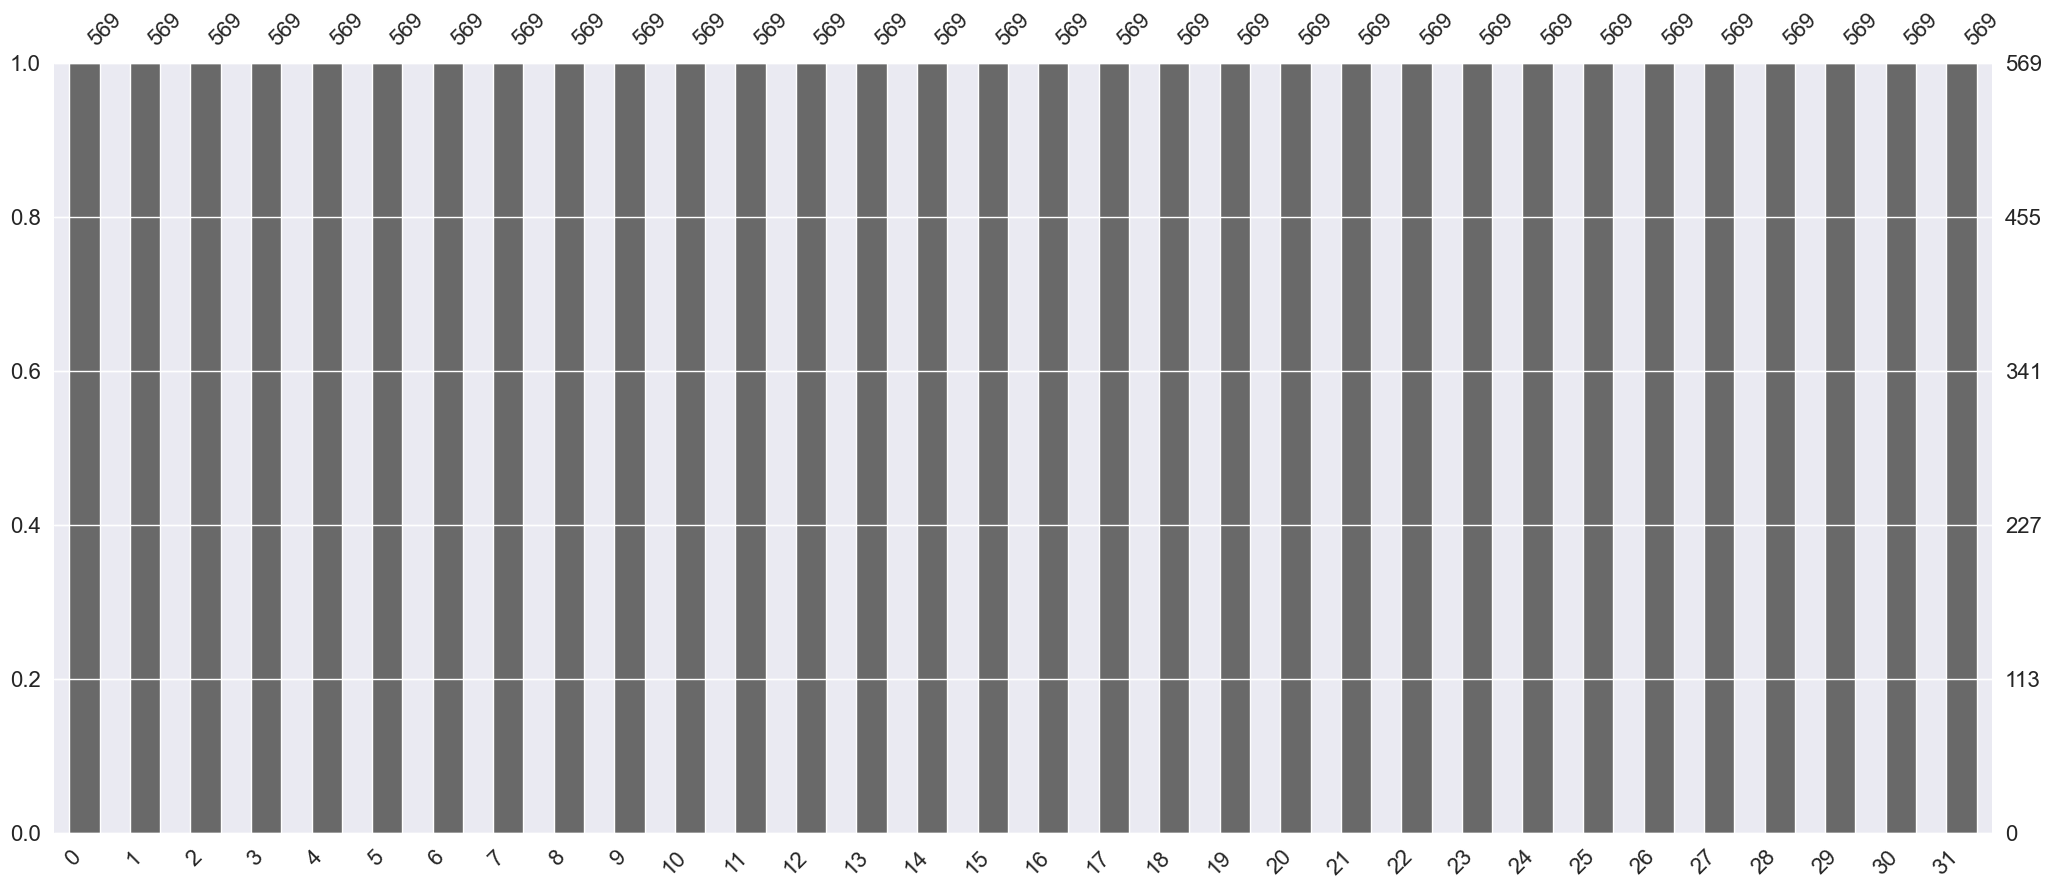

In [6]:
# Check for missing values
import missingno as msno
from missingno import bar
msno.bar(df)

Data is 100% complete.

In [27]:
# Distribution of variables
df2 = pd.DataFrame(X)
for i in df2.columns[2:5]:
    fig = px.histogram(df2, 
                   x=i, 
                   marginal='box', 
                   text_auto=True,
                   color_discrete_sequence  = ['steelblue'],
                   template='simple_white')
                #    title=i.upper() + ' HISTOGRAM')

    fig.update_layout(xaxis_title=i, yaxis_title="Count", bargap=0.1)
    fig.show()

Looking above at 3 random variables, we can see multiple outliers presence.

In [28]:
# Dependent variable weights
df[1].value_counts()

B    357
M    212
Name: 1, dtype: int64

### Standard classification methods
In this section we are defining several functions for batch-evaluating different models. 

In [9]:
from numpy import mean
from numpy import std

# dictionary of models to be evaluated
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression(max_iter=1000)
	alpha = [0.1, 0.2, 0.3]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# nonlinear models
	n_neighbors = range(3, 10)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# additionally define and append gradient boosting models to the previously created list of models
def define_gbm_models(models=dict(), use_xgb=True):
	# define config ranges
	rates = [0.001, 0.01, 0.1]
	trees = [100,500]
	depth = [3, 7, 9]
	# adding consecutive configurations
	for l in rates:
		for e in trees:
			for d in depth:
				cfg = [l, e, d]#[l, e, s, d]
				if use_xgb:
					name = 'xgb-' + str(cfg)
					models[name] = XGBClassifier(learning_rate=l, n_estimators=e, max_depth=d)
				else:
					name = 'gbm-' + str(cfg)
					models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, max_depth=d)
	print('Defined %d models' % len(models))
	return models

# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=skf, verbose=5)
	return scores
 
# evaluate a single model and try to trap errors and hide warnings
def hidden_evaluate_mode(X, y, model, folds, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric)
	except:
		scores = None
	return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=3, metric='accuracy'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = hidden_evaluate_mode(X, y, model, folds, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k, mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	plt.boxplot(scores, labels=names)
	_, labels = plt.xticks()
	plt.setp(labels, rotation=90)
	plt.savefig('spotcheck.png')

# get model list
models = define_models()
models = define_gbm_models(models)

Defined 26 models
Defined 44 models


We are also defining pipeline to scale the variables with RobustScaler() due to presence of outliers and perform Principal Compoent Analysis to reduce feature space.

In [10]:
#DEFINING PIPELINE
def make_pipeline(model):

    numeric_transformer = Pipeline(steps=[
        # ('imputer', SimpleImputer(strategy='mean')),
        ('standard_scaler', RobustScaler()),
        ('pca', PCA())#n_components=0.9, svd_solver='full'))
    ])
    preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, slice(2,32)),
        # ('categorical', categorical_transformer, categorical_features)
    ]) 

    pipeline = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('model', model)
            ])
    return pipeline
# Call function once to show a sample pipeline
make_pipeline(model = models['logistic'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler()),
                                                                  ('pca',
                                                                   PCA())]),
                                                  slice(2, 32, None))])),
                ('model', LogisticRegression(max_iter=1000))])

Now we evaluate pre-prepared dictionary of models with 3-fold cross validation on the training set.

In [12]:
import time
# Start timer for assessing batch-testing of multiple models
start = time.time()
# call function for batch-evaluating dictionary of models of training split
results_2 = evaluate_models(X_train, y_train, models)
end = time.time()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.971) total time=   0.0s
[CV] END ................................ score: (test=0.965) total time=   0.0s
[CV] END ................................ score: (test=0.982) total time=   0.0s
>logistic: 0.973 (+/-0.007)
[CV] END ................................ score: (test=0.965) total time=   0.0s
[CV] END ................................ score: (test=0.918) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.965) total time=   0.0s
>ridge-0.1: 0.949 (+/-0.022)
[CV] END ................................ score: (test=0.965) total time=   0.0s
[CV] END ................................ score: (test=0.918) total time=   0.0s
[CV] END ................................ score: (test=0.965) total time=   0.0s
>ridge-0.2: 0.949 (+/-0.022)
[CV] END ................................ score: (test=0.965) total time=   0.0s
[CV] END ................................ score: (test=0.918) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.965) total time=   0.0s
>ridge-0.3: 0.949 (+/-0.022)
[CV] END ................................ score: (test=0.971) total time=   0.0s
[CV] END ................................ score: (test=0.971) total time=   0.0s
[CV] END ................................ score: (test=0.965) total time=   0.0s
>sgd: 0.969 (+/-0.003)
[CV] END ................................ score: (test=0.977) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.953) total time=   0.0s
[CV] END ................................ score: (test=0.976) total time=   0.0s
>pa: 0.969 (+/-0.011)
[CV] END ................................ score: (test=0.965) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.936) total time=   0.0s
[CV] END ................................ score: (test=0.935) total time=   0.0s
>knn-3: 0.945 (+/-0.014)
[CV] END ................................ score: (test=0.959) total time=   0.0s
[CV] END ................................ score: (test=0.918) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.941) total time=   0.1s
>knn-4: 0.939 (+/-0.017)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.965) total time=   0.4s
[CV] END ................................ score: (test=0.924) total time=   0.0s
[CV] END ................................ score: (test=0.941) total time=   0.0s
>knn-5: 0.943 (+/-0.017)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.971) total time=   0.0s
[CV] END ................................ score: (test=0.918) total time=   0.0s
[CV] END ................................ score: (test=0.953) total time=   0.0s
>knn-6: 0.947 (+/-0.022)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.965) total time=   0.0s
[CV] END ................................ score: (test=0.924) total time=   0.0s
[CV] END ................................ score: (test=0.959) total time=   0.0s
>knn-7: 0.949 (+/-0.018)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.977) total time=   0.0s
[CV] END ................................ score: (test=0.906) total time=   0.0s
[CV] END ................................ score: (test=0.959) total time=   0.0s
>knn-8: 0.947 (+/-0.030)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.977) total time=   0.1s
[CV] END ................................ score: (test=0.924) total time=   0.0s
[CV] END ................................ score: (test=0.965) total time=   0.0s
>knn-9: 0.955 (+/-0.023)
[CV] END ................................ score: (test=0.901) total time=   0.0s
[CV] END ................................ score: (test=0.854) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.882) total time=   0.0s
>cart: 0.879 (+/-0.019)
[CV] END ................................ score: (test=0.830) total time=   0.0s
[CV] END ................................ score: (test=0.731) total time=   0.0s
[CV] END ................................ score: (test=0.724) total time=   0.0s
>extra: 0.762 (+/-0.049)
[CV] END ................................ score: (test=0.977) total time=   0.0s
[CV] END ................................ score: (test=0.971) total time=   0.0s
[CV] END ................................ score: (test=0.976) total time=   0.0s
>svml: 0.975 (+/-0.003)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

[CV] END ................................ score: (test=0.883) total time=   0.0s
[CV] END ................................ score: (test=0.842) total time=   0.0s
[CV] END ................................ score: (test=0.894) total time=   0.0s
>svmp: 0.873 (+/-0.022)
[CV] END ................................ score: (test=0.965) total time=   0.0s
[CV] END ................................ score: (test=0.871) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.941) total time=   0.0s
>svmr0.1: 0.926 (+/-0.040)
[CV] END ................................ score: (test=0.965) total time=   0.0s
[CV] END ................................ score: (test=0.901) total time=   0.0s
[CV] END ................................ score: (test=0.947) total time=   0.0s
>svmr0.2: 0.938 (+/-0.027)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.965) total time=   0.0s
[CV] END ................................ score: (test=0.906) total time=   0.0s
[CV] END ................................ score: (test=0.965) total time=   0.0s
>svmr0.3: 0.945 (+/-0.028)
[CV] END ................................ score: (test=0.889) total time=   0.0s
[CV] END ................................ score: (test=0.795) total time=   0.0s
[CV] END ................................ score: (test=0.847) total time=   0.0s
>bayes: 0.844 (+/-0.038)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.930) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ................................ score: (test=0.901) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ................................ score: (test=0.959) total time=   0.5s
>ada: 0.930 (+/-0.024)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.936) total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ................................ score: (test=0.865) total time=   1.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END ................................ score: (test=0.935) total time=   1.4s
>bag: 0.912 (+/-0.033)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.959) total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ................................ score: (test=0.883) total time=   1.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END ................................ score: (test=0.941) total time=   0.9s
>rf: 0.928 (+/-0.032)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.971) total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ................................ score: (test=0.889) total time=   1.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END ................................ score: (test=0.947) total time=   1.5s
>et: 0.936 (+/-0.034)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.942) total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ................................ score: (test=0.871) total time=   0.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END ................................ score: (test=0.965) total time=   1.4s
>gbm: 0.926 (+/-0.040)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.924) total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ................................ score: (test=0.848) total time=   1.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END ................................ score: (test=0.900) total time=   0.3s
>xgb-[0.001, 100, 3]: 0.891 (+/-0.032)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.936) total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ................................ score: (test=0.854) total time=   1.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] END ................................ score: (test=0.906) total time=   1.4s
>xgb-[0.001, 100, 7]: 0.898 (+/-0.034)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.936) total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ................................ score: (test=0.854) total time=   2.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] END ................................ score: (test=0.906) total time=   0.5s
>xgb-[0.001, 100, 9]: 0.898 (+/-0.034)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.924) total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ................................ score: (test=0.865) total time=   1.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END ................................ score: (test=0.918) total time=   1.7s
>xgb-[0.001, 500, 3]: 0.902 (+/-0.026)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.947) total time=   2.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ................................ score: (test=0.860) total time=   2.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] END ................................ score: (test=0.924) total time=   2.1s
>xgb-[0.001, 500, 7]: 0.910 (+/-0.037)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.947) total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ................................ score: (test=0.860) total time=   2.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] END ................................ score: (test=0.924) total time=   2.1s
>xgb-[0.001, 500, 9]: 0.910 (+/-0.037)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.936) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ................................ score: (test=0.871) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ................................ score: (test=0.935) total time=   0.3s
>xgb-[0.01, 100, 3]: 0.914 (+/-0.030)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.942) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ................................ score: (test=0.889) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ................................ score: (test=0.929) total time=   0.4s
>xgb-[0.01, 100, 7]: 0.920 (+/-0.023)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.942) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ................................ score: (test=0.889) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ................................ score: (test=0.929) total time=   0.4s
>xgb-[0.01, 100, 9]: 0.920 (+/-0.023)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.942) total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ................................ score: (test=0.901) total time=   1.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] END ................................ score: (test=0.971) total time=   1.8s
>xgb-[0.01, 500, 3]: 0.938 (+/-0.029)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.953) total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ................................ score: (test=0.901) total time=   1.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] END ................................ score: (test=0.965) total time=   2.2s
>xgb-[0.01, 500, 7]: 0.940 (+/-0.028)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.953) total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ................................ score: (test=0.901) total time=   3.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] END ................................ score: (test=0.965) total time=   5.9s
>xgb-[0.01, 500, 9]: 0.940 (+/-0.028)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.942) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ................................ score: (test=0.918) total time=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ................................ score: (test=0.965) total time=   0.2s
>xgb-[0.1, 100, 3]: 0.941 (+/-0.019)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.947) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ................................ score: (test=0.906) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ................................ score: (test=0.971) total time=   0.5s
>xgb-[0.1, 100, 7]: 0.941 (+/-0.027)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.947) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ................................ score: (test=0.906) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ................................ score: (test=0.971) total time=   0.2s
>xgb-[0.1, 100, 9]: 0.941 (+/-0.027)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.936) total time=   2.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ................................ score: (test=0.936) total time=   4.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV] END ................................ score: (test=0.959) total time=   4.8s
>xgb-[0.1, 500, 3]: 0.943 (+/-0.011)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.947) total time=   3.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END ................................ score: (test=0.924) total time=   4.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


[CV] END ................................ score: (test=0.971) total time=   3.4s
>xgb-[0.1, 500, 7]: 0.947 (+/-0.019)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.947) total time=   3.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END ................................ score: (test=0.924) total time=   5.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV] END ................................ score: (test=0.971) total time=   7.7s
>xgb-[0.1, 500, 9]: 0.947 (+/-0.019)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.0s finished


In [19]:
print("Execution time: ",(end-start), "s")

Execution time:  120.1248710155487 s



Rank=1, Name=svml, Score=0.975 (+/- 0.003)
Rank=2, Name=logistic, Score=0.973 (+/- 0.007)
Rank=3, Name=pa, Score=0.969 (+/- 0.011)
Rank=4, Name=sgd, Score=0.969 (+/- 0.003)
Rank=5, Name=knn-9, Score=0.955 (+/- 0.023)
Rank=6, Name=ridge-0.3, Score=0.949 (+/- 0.022)
Rank=7, Name=ridge-0.2, Score=0.949 (+/- 0.022)
Rank=8, Name=ridge-0.1, Score=0.949 (+/- 0.022)
Rank=9, Name=knn-7, Score=0.949 (+/- 0.018)
Rank=10, Name=xgb-[0.1, 500, 9], Score=0.947 (+/- 0.019)
Rank=11, Name=xgb-[0.1, 500, 7], Score=0.947 (+/- 0.019)
Rank=12, Name=knn-8, Score=0.947 (+/- 0.030)
Rank=13, Name=knn-6, Score=0.947 (+/- 0.022)
Rank=14, Name=svmr0.3, Score=0.945 (+/- 0.028)
Rank=15, Name=knn-3, Score=0.945 (+/- 0.014)
Rank=16, Name=xgb-[0.1, 500, 3], Score=0.943 (+/- 0.011)
Rank=17, Name=knn-5, Score=0.943 (+/- 0.017)
Rank=18, Name=xgb-[0.1, 100, 9], Score=0.941 (+/- 0.027)
Rank=19, Name=xgb-[0.1, 100, 7], Score=0.941 (+/- 0.027)
Rank=20, Name=xgb-[0.1, 100, 3], Score=0.941 (+/- 0.019)


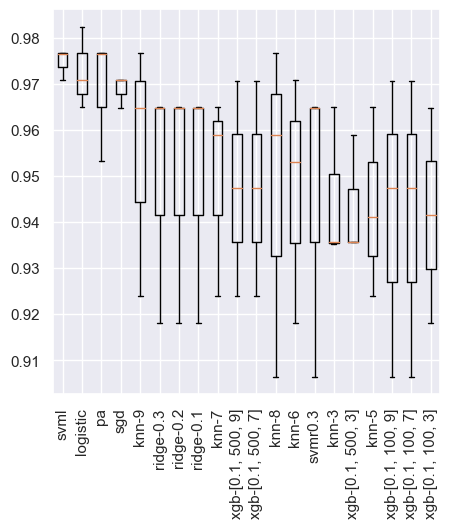

In [20]:
#Results of batch-searching through multiple models
summarize_results(results_2, top_n=20)

In [21]:
# Define model and pipeline
model_svcl = SVC()
pipe_svcl = make_pipeline(model_svcl)

# Define search grid
grid = GridSearchCV(
    estimator=pipe_svcl,
    param_grid={'model__degree': [_ for _ in np.linspace(1, 5, 5)],
                'model__kernel': [_ for _ in ['linear', 'poly', 'rbf']]},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score),
             'accuracy': make_scorer(accuracy_score)},
    refit='accuracy',
    return_train_score=False,
    cv=10,
    n_jobs=1
)
# Fit the model
grid.fit(X_train, y_train);

In [190]:
df_results = pd.DataFrame(grid.cv_results_)
df_1 = df_results[df_results['param_model__kernel'] == 'poly']
df_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__degree,param_model__kernel,params,split0_test_precision,split1_test_precision,split2_test_precision,...,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
1,0.139108,0.058178,0.009301,0.001345,1.0,poly,"{'model__degree': 1.0, 'model__kernel': 'poly'}",0.95,1.0,0.947368,...,1.000000,0.960784,0.941176,0.980392,0.941176,1.000000,0.960784,0.970664,0.021890,6
4,0.100606,0.054840,0.012901,0.009985,2.0,poly,"{'model__degree': 2.0, 'model__kernel': 'poly'}",1.00,1.0,1.000000,...,0.843137,0.803922,0.784314,0.823529,0.784314,0.862745,0.764706,0.810558,0.028985,14
7,0.072704,0.036425,0.008700,0.001900,3.0,poly,"{'model__degree': 3.0, 'model__kernel': 'poly'}",1.00,1.0,1.000000,...,0.882353,0.882353,0.882353,0.980392,0.843137,0.921569,0.803922,0.882805,0.047106,12
10,0.173710,0.125013,0.011501,0.002500,4.0,poly,"{'model__degree': 4.0, 'model__kernel': 'poly'}",1.00,1.0,1.000000,...,0.764706,0.803922,0.784314,0.823529,0.745098,0.823529,0.725490,0.783220,0.033075,15
13,0.070704,0.027628,0.010901,0.002071,5.0,poly,"{'model__degree': 5.0, 'model__kernel': 'poly'}",1.00,1.0,1.000000,...,0.784314,0.823529,0.843137,0.882353,0.803922,0.843137,0.784314,0.822247,0.029699,13


In [84]:
df_mean = df_results.groupby('param_model__kernel').agg('mean')
df_mean.mean_test_accuracy

param_model__kernel
linear    0.968741
poly      0.853899
rbf       0.970701
Name: mean_test_accuracy, dtype: float64

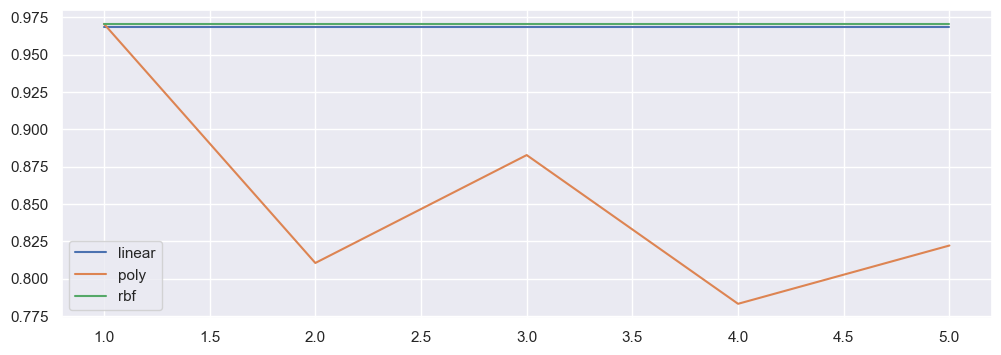

In [85]:
# Plot grid-search results
plt.figure(figsize=(12, 4))
for kernel in df_results.param_model__kernel.unique():
    plt.plot(df_results[df_results['param_model__kernel'] == kernel].param_model__degree,
            df_results[df_results['param_model__kernel'] == kernel].mean_test_accuracy,
            label = kernel)
plt.legend();

Both 1-degree polynomial model and rbf give similar values of accuracy. We choose Supported Vector Machine with rbf kernel as a final nonlinear model.

<AxesSubplot: >

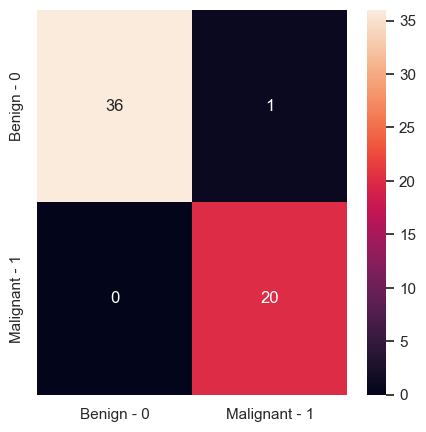

In [23]:
# Fitting final model and plotting confusion matrix
model_svc_final = SVC(kernel='rbf')
pipe_svc_final = make_pipeline(model_svcl)
pipe_svc_final.fit(X_train, y_train)
y_pred = pipe_svc_final.predict(X_test)
y_pred = (y_pred > 0.50)
cm = confusion_matrix(y_test, y_pred)
cat = ['Benign - 0', 'Malignant - 1']
sns.heatmap(cm, annot = True, xticklabels = cat, yticklabels = cat)

In case of SVC model only 1 case is classified incorrectly on the test set.

### Artificial Neural Network
This time simple architecture of neural network is defined using keras package.

In [184]:
from keras import backend as K
del model_deep
K.clear_session()

model_deep = Sequential(
    [
        Dense(units=32, activation='relu', kernel_initializer="uniform" ,input_shape=(30,)),
        Dropout(rate=0.1),
        Dense(units=32, activation='relu', kernel_initializer="uniform"),
        Dropout(rate=0.1),
        Dense(units=1, activation='sigmoid'),
    ]
)
model_deep.layers
model_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_deep.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


In [185]:
# Fitting the ANN model
start_n = time.time()
model_deep.fit(X_train, y_train, batch_size=100, epochs=400)
end_n = time.time()

Epoch 1/400
6/6 [==============================] - 2s 4ms/step - loss: 1.1306 - accuracy: 0.4453
Epoch 2/400
6/6 [==============================] - 0s 8ms/step - loss: 0.7455 - accuracy: 0.5898
Epoch 3/400
6/6 [==============================] - 0s 18ms/step - loss: 0.7273 - accuracy: 0.6543
Epoch 4/400
6/6 [==============================] - 0s 8ms/step - loss: 0.6203 - accuracy: 0.5566
Epoch 5/400
6/6 [==============================] - 0s 8ms/step - loss: 0.5975 - accuracy: 0.7617
Epoch 6/400
6/6 [==============================] - 0s 7ms/step - loss: 0.5526 - accuracy: 0.7832
Epoch 7/400
6/6 [==============================] - 0s 7ms/step - loss: 0.5231 - accuracy: 0.7695
Epoch 8/400
6/6 [==============================] - 0s 8ms/step - loss: 0.4916 - accuracy: 0.8086
Epoch 9/400
6/6 [==============================] - 0s 5ms/step - loss: 0.4288 - accuracy: 0.8613
Epoch 10/400
6/6 [==============================] - 0s 5ms/step - loss: 0.4108 - accuracy: 0.8457
Epoch 11/400
6/6 [==========

In [188]:
print("Execution time: ",(end_n-start_n), "s")

Execution time:  28.512630701065063 s


In [186]:
# Obtaining test set accuracy score
cm = 0
y_pred = model_deep.predict(X_test)
y_pred = (y_pred > 0.50)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: {}%".format(((cm[0][0] + cm[1][1])/len(y_test))*100))

2/2 [==============================] - 0s 4ms/step
Accuracy: 96.49122807017544%


<AxesSubplot: >

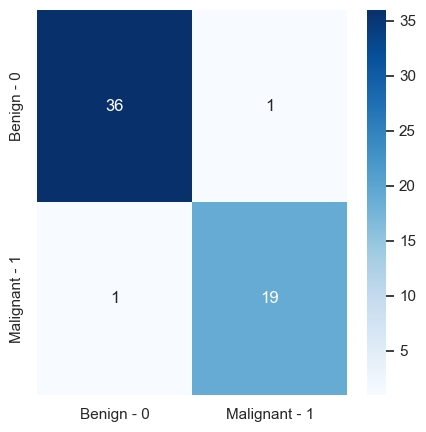

In [191]:
# Plotting confidence matrix
cat = ['Benign - 0', 'Malignant - 1']
sns.heatmap(cm, annot = True, xticklabels= cat, yticklabels = cat, cmap = 'Blues')

### Conclusions
As we see both methods can yield similar results. In the particular case ANN architecture gave 1 missclassification case more than Supporter Vector Machine model. 
Execution time of coarse search through multiple models plus fine grid-search of the best model took 137 seconds. On the same machine ANN fitting took 29 seconds. However preparing and testing multiple architectures of neural network to find one working properly on this particular dataset took significant amount of time, while searching and fitting through standard models was just running simple search functions. It is necessary to create similar methods for looping through multiple neural network architecture to compare both methods in terms of exectution time.
It might be more beneficial to use simpler models first on small datasets like this as neural networks tend to work better with large training input sizes in general.